# Query By Committee

In this notebook we will combine the classifiers studied in the last notebook to implement the query by committee query strategy.
***

In [1]:
## Imports ##

import numpy as np

# matplotlib
import matplotlib as mlp
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification

# skactiveml
from skactiveml.classifier import SklearnClassifier, ParzenWindowClassifier, MixtureModelClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.pool import QueryByCommittee
from skactiveml.pool import RandomSampling
from skactiveml.utils import unlabeled_indices, labeled_indices, MISSING_LABEL
from skactiveml.visualization import plot_decision_boundary, plot_utilities

# set warnings
import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

[We already know](https://dsgissin.github.io/DiscriminativeActiveLearning/) that active learning algorithms can drastically reduce the amount of samples needed to be labeled in order to obtain good accuracy. We will now look at the accuracy when we use imbalanced data.

In [2]:
def get_data(weights=None, random_state=0):
    X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, random_state=random_state)
    Xi, yi = make_classification(n_samples=100, n_features=2, n_redundant=0, weights=weights, random_state=random_state)
    return (X, y, Xi, yi)

In [3]:
def get_accuracy_uncertainty(weights=None, cycles=30, **kwargs):
    data = []
    for rand in range(100):
        qs = UncertaintySampling(random_state=rand, **kwargs)
        X, y_true, Xi, yi_true = get_data(weights=weights, random_state=rand)
        yi = np.full(shape=yi_true.shape, fill_value=MISSING_LABEL)
        out = []
        clf = SklearnClassifier(LogisticRegression(), classes=np.unique(y_true))

        clf.fit(Xi, yi)
        for _ in range(cycles):
            i = qs.query(Xi, yi, clf)
            yi[i] = yi_true[i]
            clf.fit(Xi,yi)
            out.append(clf.score(X,y_true))
        data.append(out)

    return np.mean(np.array(data), axis=0)

def get_accuracy_committee(weights=None, cycles=30, **kwargs):
    data = []
    for rand in range(100):
        qs = QueryByCommittee(random_state=rand, **kwargs)
        X, y_true, Xi, yi_true = get_data(weights=weights, random_state=rand)
        yi = np.full(shape=yi_true.shape, fill_value=MISSING_LABEL)
        out = []
        clfs = [SklearnClassifier(LogisticRegression(), classes=np.unique(y_true)),
                SklearnClassifier(SGDClassifier(loss='modified_huber'), classes=np.unique(y_true)),
                ParzenWindowClassifier(classes=np.unique(y_true)),
                MixtureModelClassifier(classes=np.unique(y_true))
               ]
                
        
        for clf in clfs:
            clf.fit(Xi, yi)
        for _ in range(cycles):
            i = qs.query(Xi, yi, clfs)
            yi[i] = yi_true[i]
            for clf in clfs:
                clf.fit(Xi, yi)
            out.append(clf.score(X,y_true))
        data.append(out)

    return np.mean(np.array(data), axis=0)

In [4]:
def plot_accuracy(title, accuracies, ax):
    c = np.arange(len(accuracies[0][0]))
    for i in range(len(accuracies)):
        ax.plot(c, accuracies[i][0], label=accuracies[i][1])

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Samples asked at oracle')
    ax.set_title(title)
    ax.legend()


In [5]:
acc_uncertainty = get_accuracy_uncertainty()

In [6]:
acc_committee = get_accuracy_committee()

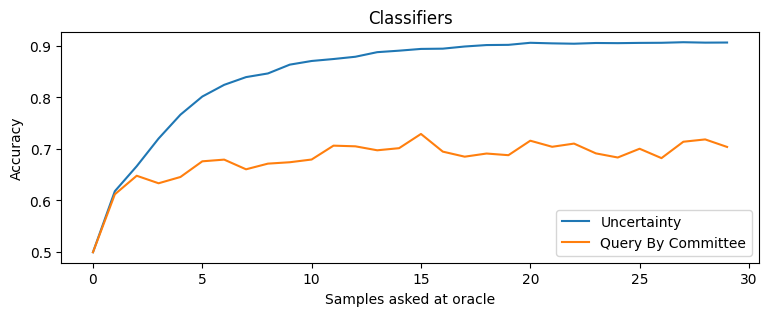

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 3))

plot_accuracy('Classifiers', [[acc_uncertainty, "Uncertainty"], [acc_committee, "Query By Committee"]], axs)

fig.show()